### TODOS: Wrap in Function, HPO, Class imbalance

In [1]:
import numpy as np
import pandas as pd 
import h5py

In [2]:
#Modelling libraries
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.feature_selection import VarianceThreshold <- use to remove low variance features

#from bayes_opt import BayesianOptimization #!pip install bayesian-optimization

In [3]:
# file_path = r"C:\Users\likai\Desktop\My Life\Master\3. Semester\Innolabs\Connectome Git\00_Data\Results"
file_path = r"C:\Users\katha\Downloads\Test"

In [4]:
data = pd.read_csv(file_path + '\\train.csv')
test = pd.read_csv(file_path + '\\test.csv')

In [5]:
data.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
0,241.0,40ea07c4b,17.0,70.0,20.04.2017,0.0,2.0,13.0,-0.704825,1.0,...,0.748460,0.672616,0.293294,0.160400,1.062753,0.071058,0.117238,0.129523,0.083228,0.902359
1,447.0,9017e3b68,13.0,69.0,22.04.2015,0.0,1.0,18.0,-0.070936,0.0,...,0.389067,0.475096,0.135471,-0.109216,0.456896,0.109648,0.123226,0.146611,0.130343,0.344798


In [6]:
#features.describe()
round(data.describe(), 2)

,ConnID,siteid,age,sex,prmdiag,edyears,MEM_score,Apoe,IDs,1_2,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
count,649.00,649.00,649.00,649.0,649.00,649.00,649.00,634.00,649.00,649.00,...,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00
mean,404.80,10.65,70.65,0.5,1.18,14.63,0.28,0.31,404.80,0.71,...,0.51,0.41,0.05,0.13,0.56,0.09,0.17,0.07,0.09,0.51
std,232.58,5.39,6.03,0.5,1.13,2.92,0.71,0.46,232.58,0.27,...,0.22,0.20,0.18,0.20,0.24,0.20,0.21,0.17,0.19,0.23
min,1.00,2.00,60.00,0.0,0.00,8.00,-2.43,0.00,1.00,-0.00,...,0.00,-0.25,-0.54,-0.46,-0.09,-0.52,-0.63,-0.58,-0.75,-0.55
25%,199.00,5.00,66.00,0.0,0.00,12.00,-0.13,0.00,199.00,0.54,...,0.35,0.27,-0.08,-0.01,0.39,-0.04,0.04,-0.03,-0.02,0.35
50%,405.00,11.00,71.00,1.0,1.00,14.00,0.38,0.00,405.00,0.70,...,0.51,0.41,0.06,0.12,0.55,0.09,0.17,0.07,0.09,0.50
75%,606.00,16.00,75.00,1.0,2.00,17.00,0.79,1.00,606.00,0.87,...,0.66,0.53,0.17,0.26,0.71,0.20,0.30,0.18,0.21,0.67
max,813.00,18.00,88.00,1.0,4.00,20.00,1.74,1.00,813.00,1.71,...,1.34,1.36,0.64,0.78,1.32,0.77,0.88,0.59,0.97,1.19


In [7]:
#define target
data['prmdiag'].value_counts()

1.0    288
0.0    184
2.0    116
4.0     61
Name: prmdiag, dtype: int64

In [8]:
has_alzheimer = data.prmdiag.isin([2,3])
no_alzheimer = data.prmdiag.isin([0])

data.loc[has_alzheimer, 'target'] = 1
data.loc[no_alzheimer, 'target'] = 0

In [9]:
data.dropna(subset=['target'], axis = 0, inplace = True)

In [10]:
data.drop(['ConnID','Repseudonym','visdat','siteid','IDs', 'prmdiag'], axis = 1, inplace = True)

In [11]:
features = data.drop('target', axis = 1)
labels = data['target']

In [12]:
n_features = features.shape[1]

In [13]:
#same for test file
has_alzheimer = test.prmdiag.isin([2,3])
no_alzheimer = test.prmdiag.isin([0])

test.loc[has_alzheimer, 'target'] = 1
test.loc[no_alzheimer, 'target'] = 0

In [14]:
test.dropna(subset=['target'], axis = 0, inplace = True)

In [15]:
test.drop(['ConnID','Repseudonym','visdat','siteid','IDs', 'prmdiag'], axis = 1, inplace = True)

In [16]:
X_test = test.drop('target', axis = 1)
y_test = test['target']

### Slight Class imbalance

In [17]:
labels.value_counts()

0.0    184
1.0    116
Name: target, dtype: int64

#### Train Test Split

In [18]:
#X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_train, y_train = features, labels

#### impute missing values

In [19]:
features[features.isna().any(axis=1)]

,age,sex,edyears,MEM_score,Apoe,1_2,1_3,1_4,1_5,1_6,...,242_243,242_244,242_245,242_246,243_244,243_245,243_246,244_245,244_246,245_246
26,79.0,1.0,13.0,0.719214,NaN,0.797040,0.370490,0.059678,0.218447,-0.122462,...,0.363497,0.231037,0.252773,0.431979,0.552066,0.013893,0.161084,-0.142823,-0.075208,0.666441
230,69.0,1.0,13.0,0.708661,NaN,0.565332,0.332528,-0.015577,0.527998,0.265987,...,0.575368,0.379398,0.153072,0.188878,0.463371,0.099339,0.027374,0.127089,0.073215,0.146653
282,70.0,0.0,20.0,0.991131,NaN,0.766746,0.788925,0.356687,0.639079,0.395056,...,0.559600,0.523757,-0.067733,-0.076038,1.023225,-0.154108,-0.135015,-0.031498,0.001101,0.925360
341,65.0,1.0,13.0,0.633007,NaN,0.180014,0.477626,0.143820,-0.054953,0.315783,...,0.222863,0.351755,-0.137550,0.203394,0.164663,0.234830,0.283645,-0.168066,-0.053491,0.241715
529,66.0,1.0,16.0,0.636514,NaN,0.599700,0.172902,-0.143808,0.145856,0.150976,...,0.254868,0.230583,-0.153607,-0.086144,0.356617,0.076132,0.228457,-0.031727,-0.084820,0.349648


In [20]:
imp = KNNImputer(missing_values=np.nan, n_neighbors=7)
X_train = imp.fit_transform(X_train)
#X_valid = imp.transform(X_valid)
X_test = imp.transform(X_test)

#### Scale Data

In [21]:
scaler = StandardScaler()

In [22]:
X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Fit RF

In [23]:
# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
#rf = RandomForestClassifier(n_estimators = 200, random_state = 42, max_depth = 10, max_features= int(n_features//6))
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(n_estimators=500, random_state=42)

### Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


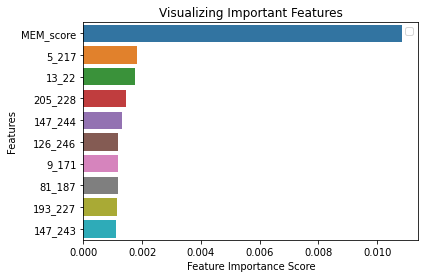

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# extract feature importance array
feature_imp = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=False)
feature_imp = feature_imp[:10]

# plot feature importance
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()


### Evaluation

In [ ]:
predictions = rf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [ ]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

In [ ]:
plot_confusion_matrix(rf, X_test, y_test)  

In [ ]:
importances = list(rf.feature_importances_)

In [ ]:
feature_list = list(features.columns)

feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:10]]

## Logistic Regression

In [ ]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

In [ ]:
params_grid = {
                 'l1_ratio': np.linspace(0,  1, 11)
             }

In [ ]:
grid_clf =  GridSearchCV(estimator = logreg, param_grid = params_grid, n_jobs = -1, cv = 10, verbose=3)

In [ ]:
grid_clf.fit(X_train, y_train)


In [ ]:
grid_clf.best_estimator_

In [ ]:
grid_clf. best_params_

In [ ]:
logreg = LogisticRegression(penalty = 'l2', solver = 'lbfgs')
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
f1 = f1_score(y_test,predictions)
auc = roc_auc_score(y_test,predictions)

In [ ]:
pd.DataFrame({"Accuracy":[accuracy], "Precision":[precision], "Recall": [recall], "F1":[f1], "AUC":[auc]})

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test)  

### PCA Pipeline - Test

In [ ]:
#X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)
X_train, y_train = features, labels

X_test = test.drop('target', axis = 1)
y_test = test['target']

In [ ]:
pipeline = Pipeline([
    ('KNN_Impute', KNNImputer(missing_values=np.nan, n_neighbors=7)),
    ('scale', StandardScaler()),
    ('PCA', PCA(n_components = .95)),
])


In [ ]:
X_train = pipeline.fit_transform(X_train)

In [ ]:
X_test = pipeline.transform(X_test)

In [ ]:
X_train.shape[1] == X_test.shape[1]

In [ ]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga')

In [ ]:
params_grid = {
                 'l1_ratio': np.linspace(0,  1, 11)
             }

In [ ]:
grd_search = GridSearchCV(estimator = logreg, param_grid = params_grid, n_jobs = -1, cv = 10, verbose=3)

In [ ]:
grd_search.fit(X_train, y_train)

In [ ]:
grd_search.best_params_

In [ ]:
logreg = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = .9)

In [ ]:
logreg.fit(X_train, y_train)

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train)

In [ ]:
log_pred = logreg.predict(X_test)
rf_pred = rf.predict(X_test)

In [ ]:
model = ['LogReg', 'RF']
accuracy = []
precision = []
recall = []
f1 = []
auc =  []

In [ ]:
#logreg
accuracy.append(accuracy_score(y_test,log_pred))
precision.append(precision_score(y_test,log_pred))
recall.append(recall_score(y_test,log_pred))
f1.append(f1_score(y_test,log_pred))
auc.append(roc_auc_score(y_test,log_pred))
#rf
accuracy.append(accuracy_score(y_test,rf_pred))
precision.append(precision_score(y_test,rf_pred))
recall.append(recall_score(y_test,rf_pred))
f1.append(f1_score(y_test,rf_pred))
auc.append(roc_auc_score(y_test,rf_pred))

In [ ]:
pd.DataFrame({'Model': model, "Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1":f1, "AUC":auc})

In [ ]:
plot_confusion_matrix(logreg, X_test, y_test)  

In [ ]:
plot_confusion_matrix(rf, X_test, y_test)  